In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image
from scipy.io import loadmat


In [2]:
pwd

'/mnt/pesaranlab/People/Capstone_students/Noah/Sleeping-Monkeys/notebooks'

In [3]:
cd ../../../Noah

/mnt/pesaranlab/People/Capstone_students/Noah


In [4]:
moving_files = os.listdir('datav3/move/')
sleeping_files = os.listdir('datav3/sleep')

In [5]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if f.split('_')[0] not in ['1803238','180329','180330','180331','180410','180411','180412', '180413']]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if f.split('_')[0] in ['180328','180329','180330','180331','180410','180411','180412', '180413']]

            
        # clean
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
       # labe
       # spec = torch.from_numpy(np.load('data/'self.all_files[idx])).unsqueeze(0)
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0] #check this out
        date = self.all_files[idx].split('_')[0]
        rec = self.all_files[idx].split('_')[1].split('_')[0]
        spec = torch.from_numpy(np.load('datav3/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  spec.resize(1,100,10) , label, date, rec

In [6]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')


In [7]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)

In [8]:
spec[0].shape

NameError: name 'spec' is not defined

/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
<ipython-input-9-91d2d80534e1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


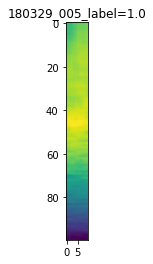

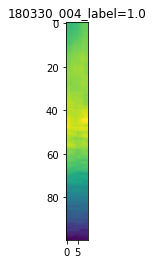

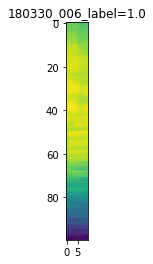

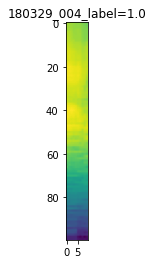

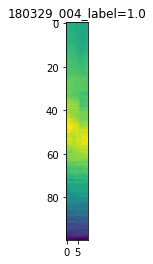

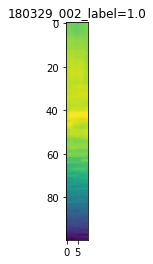

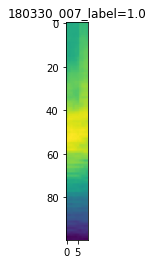

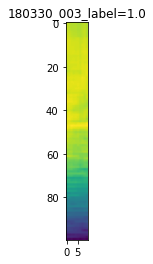

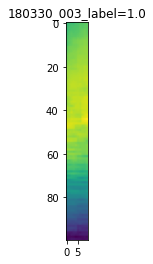

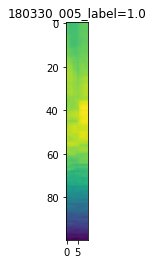

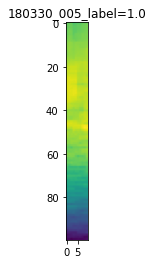

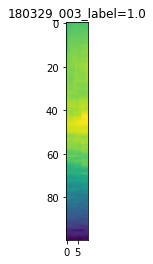

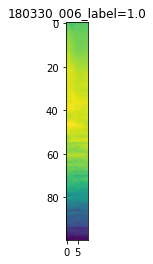

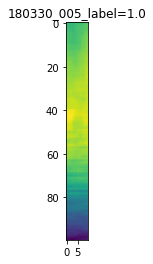

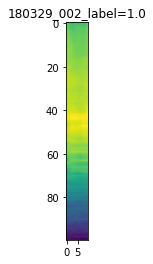

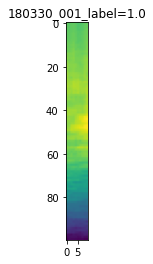

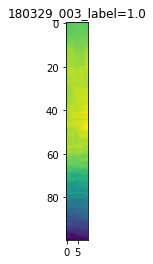

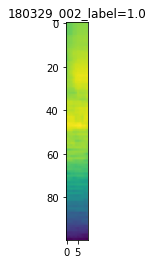

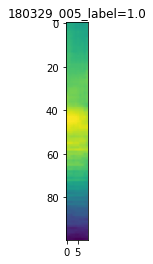

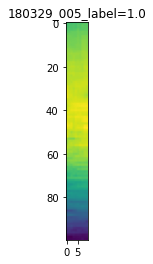

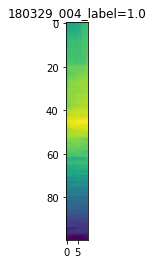

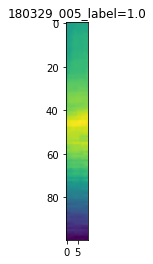

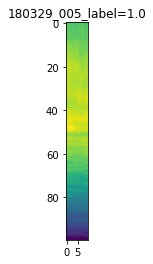

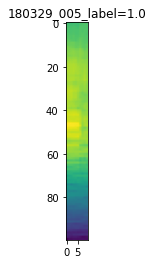

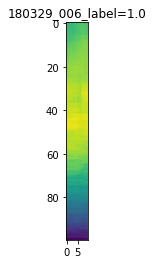

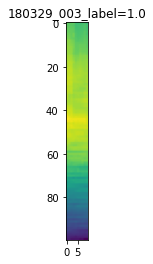

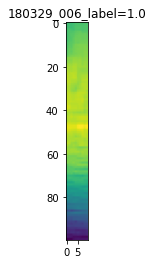

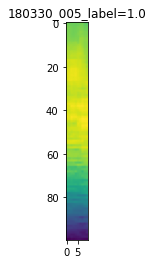

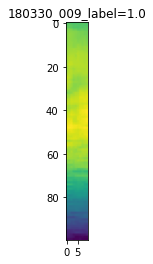

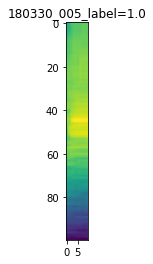

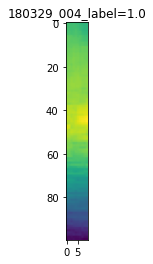

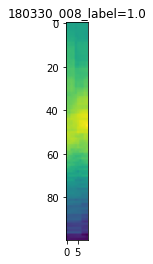

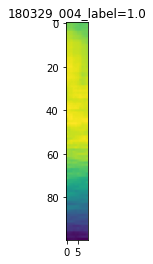

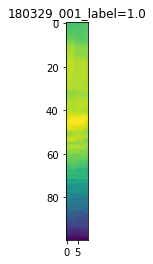

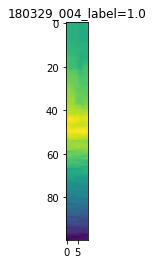

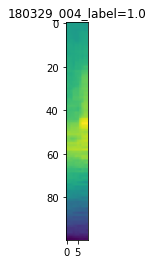

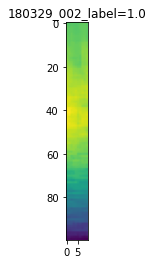

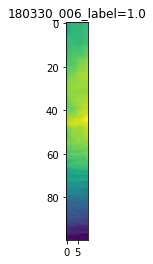

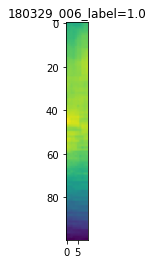

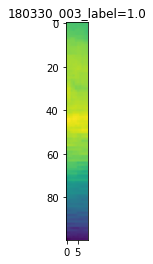

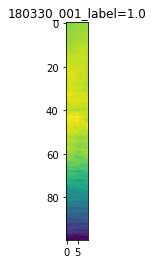

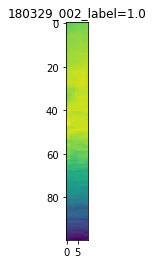

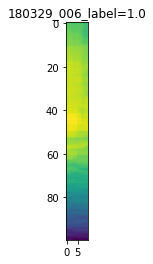

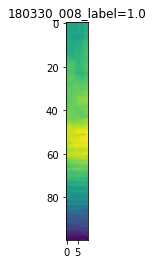

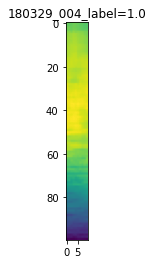

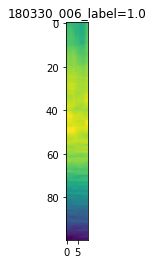

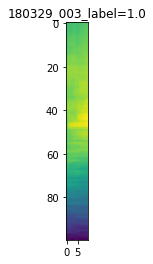

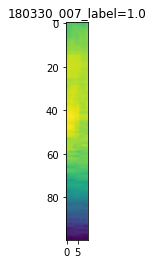

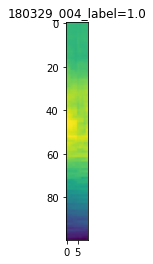

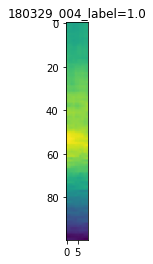

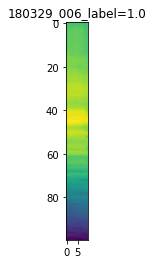

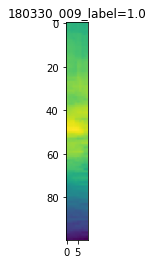

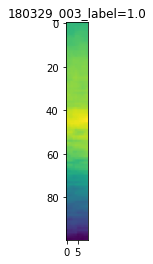

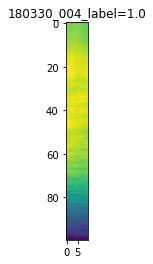

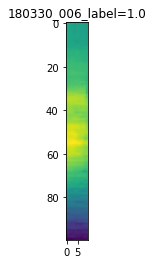

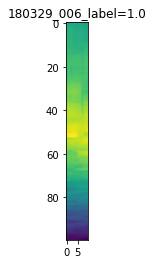

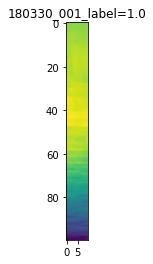

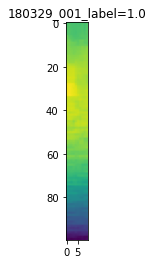

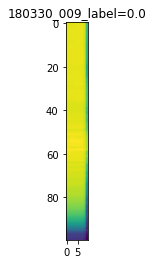

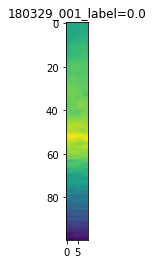

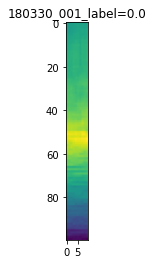

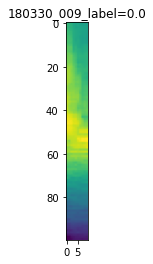

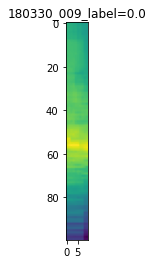

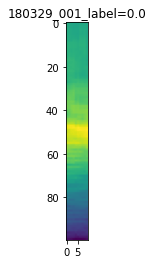

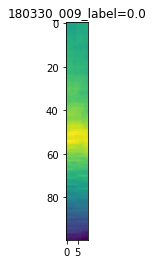

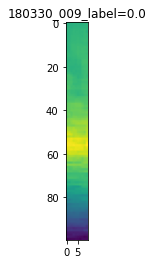

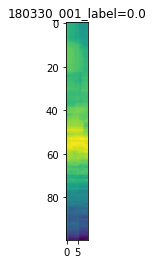

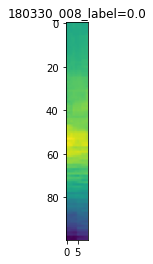

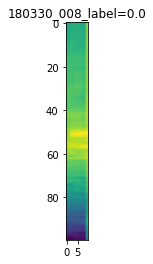

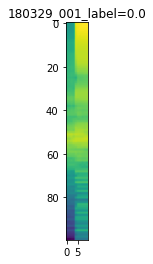

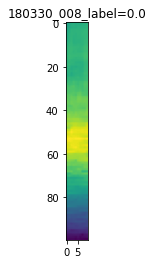

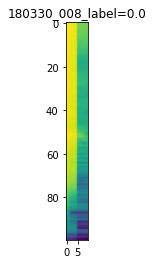

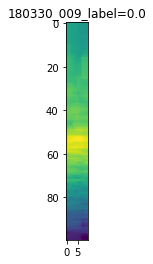

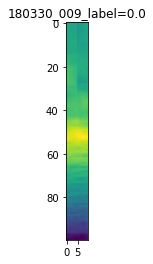

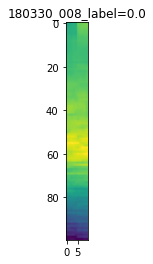

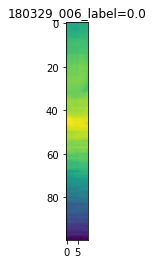

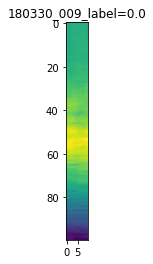

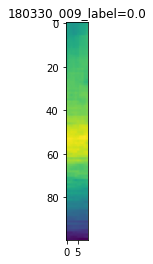

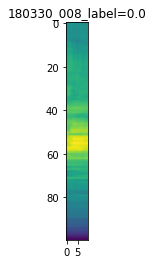

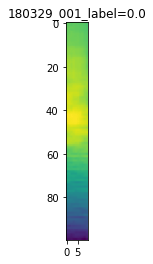

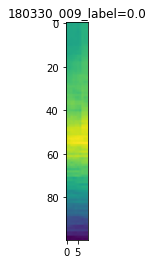

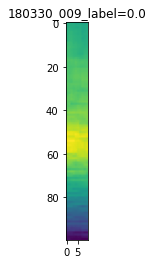

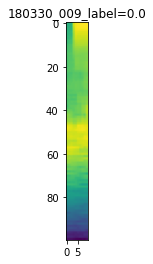

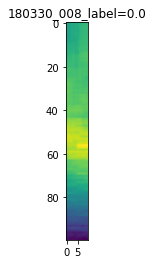

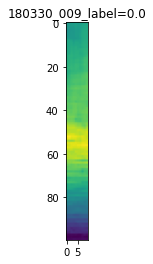

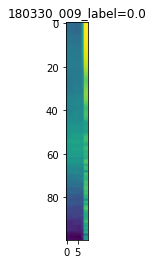

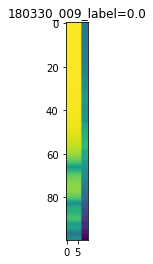

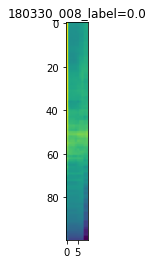

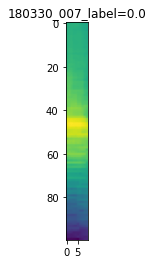

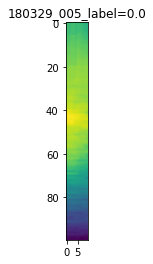

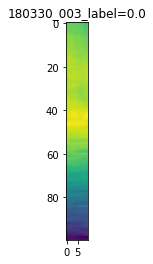

In [9]:
for spec, label, date, rec in val_loader:
    plt.figure()
    plt.title(date[0] + "_" + rec[0] + "_label=" +str(label[0].item()))
    plt.imshow(spec[0][0][:])
   # break
    

In [10]:

    
class LogReg(nn.Module):
    def __init__(self, input_dim=100*10, output_dim=1):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.resize(x.shape[0],1,10*100).float()
        outputs = torch.sigmoid(self.linear(x))
        return outputs


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 30

model = LogReg().to(device)
criterion = nn.BCELoss()#weight=torch.from_numpy(weight).float())
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [15]:
def get_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels, night, rec = data
            #images = images.mean(axis=1)
            outputs = model(images)
            predictions = []
            for o in outputs:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().numpy()).sum().item()
    return correct / total

In [16]:
def train(epoch):
    model.train()
    batch_losses = []
    
    for batch_idx, (data, labels, date, rec) in enumerate(train_loader):
        
        data = data.to(device)
      #  data = data.mean(axis=1)
        labels = labels.to(device).float()
        
        
        preds = model(data)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_loss = sum(batch_losses)/len(batch_losses)
    acc = get_accuracy(train_loader) 
    return epoch_loss,acc

def test(loader):
    model.eval()
    batch_losses = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec) in enumerate(loader):
            data = data.to(device)
         #   data = data.mean(axis=1)
            labels = labels.to(device).float()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                print('NaN in test?')
                continue
            
            preds = model(data)
            loss = criterion(preds, labels)
            
            batch_losses.append(loss)
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        
    acc = get_accuracy(loader)
    return epoch_loss,acc

In [17]:
epochs = []
training_losses = []
training_acc = []
val_losses = []
validation_acc = []

In [18]:


for epoch in range(num_epochs):
    avg_train_loss, train_acc = train(epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_acc = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    training_losses.append(avg_train_loss)
    training_acc.append(train_acc)
    val_losses.append(val_loss)
    validation_acc.append(val_acc)

/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([17, 1])) that is different to the input size (torch.Size([17, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train loss for epoch 0: 0.49928686022758484


/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Val loss for epoch 0: 0.36908063292503357
Train loss for epoch 1: 0.3794359266757965
Val loss for epoch 1: 0.33019089698791504
Train loss for epoch 2: 0.3548675775527954
Val loss for epoch 2: 0.4092235267162323
Train loss for epoch 3: 0.3428334891796112
Val loss for epoch 3: 0.3393487334251404
Train loss for epoch 4: 0.3333265483379364
Val loss for epoch 4: 0.34209516644477844
Train loss for epoch 5: 0.3245728015899658
Val loss for epoch 5: 0.48086127638816833
Train loss for epoch 6: 0.3294416666030884
Val loss for epoch 6: 0.43666818737983704
Train loss for epoch 7: 0.3235692083835602
Val loss for epoch 7: 0.41772377490997314
Train loss for epoch 8: 0.3165264427661896
Val loss for epoch 8: 0.32618656754493713
Train loss for epoch 9: 0.3141692876815796
Val loss for epoch 9: 0.34852805733680725
Train loss for epoch 10: 0.3107818067073822
Val loss for epoch 10: 0.38437578082084656
Train loss for epoch 11: 0.3042352497577667
Val loss for epoch 11: 0.33104223012924194
Train loss for epoch 

In [19]:
plt.style.use('dark_background')


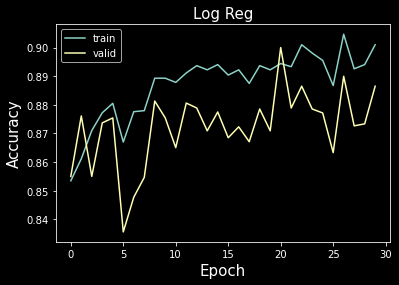

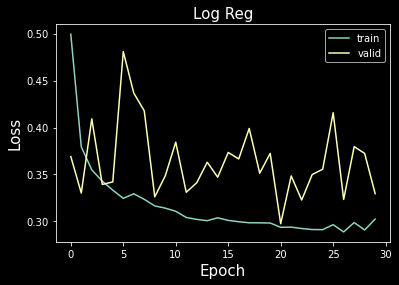

In [20]:
plt.figure()
plt.title("Log Reg", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(validation_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()

plt.figure()
plt.title("Log Reg", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()

# Visualize Weights

In [21]:
for param in model.parameters():
    print(param)
    break
    #break

Parameter containing:
tensor([[-5.4541e-02, -8.4639e-02, -4.2002e-02, -3.2698e-02, -5.5765e-02,
         -4.3387e-02, -5.3398e-02, -1.0204e-01, -1.1165e-01, -1.0632e-01,
         -5.4964e-02, -7.3979e-02, -2.5419e-02, -5.1128e-02, -3.7482e-02,
         -3.3910e-02, -4.3548e-02, -8.1012e-02, -1.1822e-01, -7.8611e-02,
         -1.3485e-02, -4.1726e-02, -9.0255e-03,  5.2927e-03,  1.6140e-02,
          9.5130e-03, -4.0433e-02, -2.8901e-02, -5.0160e-02, -6.6686e-02,
          1.2237e-02, -3.1430e-02,  3.0064e-04,  2.7931e-02, -2.2178e-02,
         -3.5467e-02, -1.7829e-02, -2.3457e-02, -3.4737e-02, -5.4292e-02,
          2.8894e-02,  1.9792e-02,  1.2724e-02,  1.6729e-02,  5.8419e-03,
          2.8570e-02,  1.8367e-02,  1.3825e-02, -1.8957e-02, -1.4476e-02,
          3.6601e-02, -2.9498e-03, -1.3900e-02,  5.8986e-02,  4.3288e-03,
          4.6208e-02,  2.8051e-02, -4.2050e-02, -1.6643e-02, -3.8899e-02,
          3.1546e-02,  8.9887e-03,  4.3704e-02, -1.5539e-03,  3.1709e-02,
          2.8193

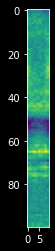

In [22]:
plt.imshow(param[0].reshape(100,10).detach().numpy())


In [ ]:
!pwd

In [ ]:
f = os.listdir('data/sleep')[0]

In [ ]:
f.split('_')[:2]

In [ ]:
spec_f = []
for f in os.listdir('data/sleep'):
    night, rec = f.split('_')[:2]
    night_rec = night + "_" + rec
    spec_f.append(night_rec)

In [ ]:
spec_f

In [ ]:
 '180410_002' in list(set(spec_f))

In [ ]:
# Examining one not used here.


spec_data = loadmat('../Spectrogram_mat_data/N10W1dn1_180331_rec002.mat')

In [ ]:
goose_files = []
for f in os.listdir('../Spectrogram_mat_data/'):
    if 'N10W1dn1' in f:
        goose_files.append(f)

In [ ]:
for gf in goose_files: #these are files that are spectrograms, but are not saved by us. 
    if gf not in list(set(spec_f)):
        print(gf)
        try:
            spec_data = loadmat('../Spectrogram_mat_data/' + gf)

            all_badtimes = np.array([])
            specs = []
            for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
                ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
                # TODO: NaN check 
                specs.append(ztotSpec)

                badtimes = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
                all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])
            all_badtimes = np.array(list(set(all_badtimes))) #method 1 
            ztotSpecs = np.stack(specs) # 62 x 100 x 7000
            print(np.isnan(ztotSpecs).sum())
        except Exception as e:
            print(e)

In [ ]:
spec_data = loadmat('../Spectrogram_mat_data/N10W1dn1_180410_rec002.mat')

In [ ]:
spec_data

In [ ]:

all_badtimes = np.array([])
specs = []
for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
    ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
    # TODO: NaN check 
    specs.append(ztotSpec)
    print(ztotSpec)
    badtimes = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
    all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])

all_badtimes = np.array(list(set(all_badtimes))) #method 1 
ztotSpecs = np.stack(specs) # 62 x 100 x 7000


In [ ]:
spec_data['Spec_per_Ch']['Ch1'][0][0]['m_start']